In [ ]:
!pip install --upgrade derivative
!pip install scikit-learn==1.0.2
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 4.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import pysindy as ps
import matplotlib.pyplot as plt
from pysindy import SINDy
from sklearn.linear_model import Lasso
from matplotlib.cm import rainbow

In [4]:
# dati italia dal 24/02/2020 al 16/3/23
df = pd.read_json('/content/dpc-covid19-ita-andamento-nazionale.json')
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df.columns)

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')


In [8]:
df_red = df[['totale_positivi','dimessi_guariti','deceduti','totale_casi']]
print(df_red.head())
rows, cols = df_red.shape

   totale_positivi  dimessi_guariti  deceduti  totale_casi
0              221                1         7          229
1              311                1        10          322
2              385                3        12          400
3              588               45        17          650
4              821               46        21          888


In [11]:
# i consider N costant, and i use k to have more manageavle data 
k = 600000
n = 60000000/k
N = np.ones(rows)*n
I = df_red.iloc[:,0]/k
R = df_red.iloc[:,1]/k
S = N - I - R

In [12]:
# create dataset SIR
data = pd.DataFrame(index=range(rows))
data.insert(loc=0,column="S",value=S)
data.insert(loc=1,column="I",value=I)
data.insert(loc=2,column="R",value=R)
data.head()

,S,I,R
0,99.999630,0.000368,0.000002
1,99.999480,0.000518,0.000002
2,99.999353,0.000642,0.000005
3,99.998945,0.000980,0.000075
4,99.998555,0.001368,0.000077


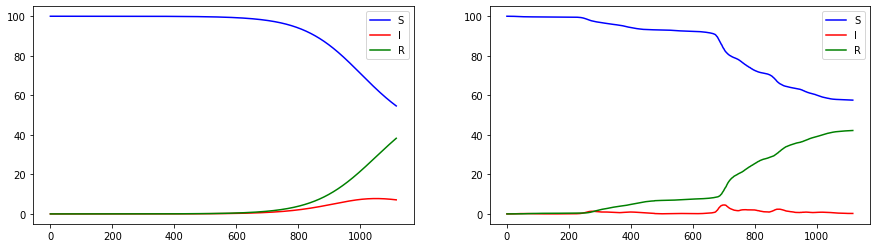

In [20]:
def SIR(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R
    dSdt = -(beta * S * I)/ N
    dIdt = (beta * S * I)/ N - gamma * I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]
    
beta = 0.03 # infection rate
gamma = 0.019 # recovery rate
t_span=[0,rows]
y0 = data.iloc[0,:]
sol = solve_ivp(SIR, t_span, y0, args=(beta, gamma), dense_output=True)
dt = 1
t = np.arange(t_span[0], t_span[1], dt)
y = sol.sol(t)
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121)
ax.plot(t,y[0,:],"b")
ax.plot(t,y[1,:],"r")
ax.plot(t,y[2,:],"g")
plt.legend(['S','I','R'])

ax = fig.add_subplot(122)
ax.plot(t,data.iloc[:,0],"b")
ax.plot(t,data.iloc[:,1],"r")
ax.plot(t,data.iloc[:,2],"g")
plt.legend(['S','I','R','D','N'])
plt.show()

(S)' = -0.005 I^2
(I)' = -0.002 I^2 + -0.001 I R
(R)' = 0.007 I^2 + 0.001 I R


<ipython-input-21-1e290254b8c2>:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1) # row 1, col 2 index 1


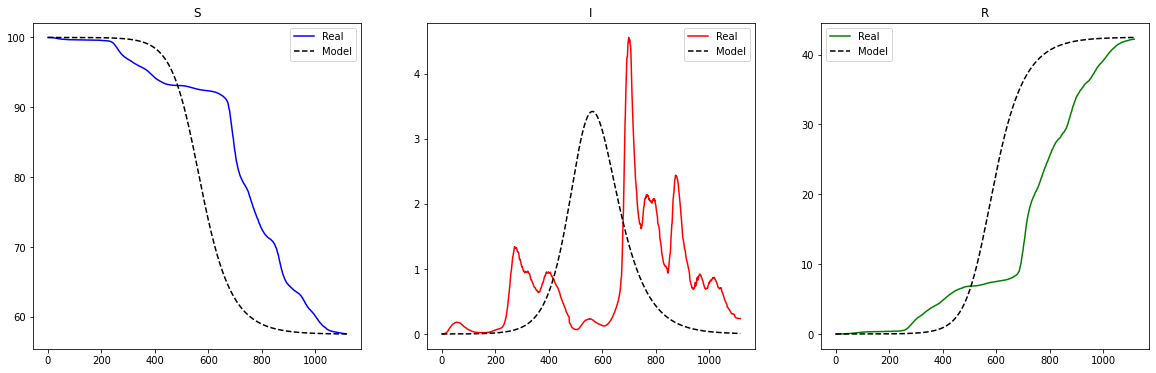

S': -0.00006 * I + -0.00041 * S I + -0.00475 * I^2 + -0.00037 * I R
I': -0.00002 * I + 0.00019 * S I + -0.00188 * I^2 + -0.00055 * I R
R': 0.00008 * I + 0.00022 * S I + 0.00663 * I^2 + 0.00092 * I R


In [21]:
l = rows
t_train=t[0:l]
s=data.iloc[:l,0]
i=data.iloc[:l,1]
r=data.iloc[:l,2]
X = np.stack((s, i,r),axis=-1)

threshold = 1e-5
alpha = 0.5
poly_order = 2

# Inizializza l'oggetto SINDy con il valore di sparsity impostato a 0.1
model = SINDy(optimizer=ps.STLSQ(threshold=threshold),feature_library = ps.PolynomialLibrary(degree=poly_order),feature_names=["S","I","R"])
#model = SINDy(optimizer=Lasso(alpha=alpha),feature_library = ps.PolynomialLibrary(degree=poly_order),feature_names=["S","I","R"])

model.fit(X,t=t_train)
model.print()

x0_train=data.iloc[0,:]
x_train=X

x_sim = model.simulate(x0_train, t_train)

fig = plt.subplots(figsize=(20,6))
plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.plot(t_train,data.iloc[:l,0],"b")
plt.plot(t_train,x_sim[:,0],"k--")
plt.title("S")
plt.legend(['Real','Model'])

plt.subplot(1, 3, 2) # row 1, col 2 index 1
plt.plot(t_train,data.iloc[:l,1],"r")
plt.plot(t_train,x_sim[:,1],"k--")
plt.title("I")
plt.legend(['Real','Model'])

plt.subplot(1, 3, 3) # row 1, col 2 index 1
plt.plot(t_train,data.iloc[:l,2],"g")
plt.plot(t_train,x_sim[:,2],"k--")
plt.title("R")
plt.legend(['Real','Model'])


plt.show()

feature_names = model.feature_library.get_feature_names()
coefficients = model.coefficients()
var = model.feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]

# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.5f} * {variable}'
    print(f"{(var[i])}': {equation}")

In [27]:
# Generate training data
l = rows
t_train=t[0:l]
s=data.iloc[:l,0]
i=data.iloc[:l,1]
r=data.iloc[:l,2]
X = np.stack((s, i,r),axis=-1)

x0_train=y0
x_train=X
x_dot_train_measured = np.array([SIR(t_train,x_train[i],beta,gamma) for i in range(t_train.size)])

threshold = 1e-5
poly_order = 2

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1]

# models adding noise to the measured derivatives
models = []
t_span_sim=[0,900]
t_sim = np.arange(t_span_sim[0], t_span_sim[1], dt)
x_sim = []
for eps in noise_levels:
    model = SINDy(optimizer=ps.STLSQ(threshold=threshold), feature_library = ps.PolynomialLibrary(degree=poly_order), feature_names=["S","I","R"])
    model.fit(x_train, t=dt, x_dot=x_dot_train_measured + np.random.normal(scale=eps, size=x_train.shape), quiet=True)
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))


In [33]:
print(models[0].equations())
print(models[1].equations())
print(models[2].equations())
print(models[3].equations())

['0.000', '0.000', '0.000']
['0.000', '0.000', '0.000']
['0.000', '0.000', '0.000']
['0.002 I^2', '-0.003 I^2', '-0.003 I^2 + 0.001 I R']


In [34]:
print('MODEL noise=1e-4')
feature_names = models[0].feature_library.get_feature_names()
coefficients = models[0].coefficients()
var = models[0].feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]
# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.5f} * {variable}'
    print(f"{(var[i])}': {equation}")

print('MODEL noise=1e-3')
feature_names = models[1].feature_library.get_feature_names()
coefficients = models[1].coefficients()
var = models[1].feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]
# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.5f} * {variable}'
    print(f"{(var[i])}': {equation}")

print('MODEL noise=1e-2')
feature_names = models[2].feature_library.get_feature_names()
coefficients = models[2].coefficients()
var = models[2].feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]
# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.5f} * {variable}'
    print(f"{(var[i])}': {equation}")

print('MODEL noise=1e-1')
feature_names = models[3].feature_library.get_feature_names()
coefficients = models[3].coefficients()
var = models[3].feature_names
feature_names = [f.replace('x0', 'S').replace('x1', 'I').replace('x2', 'R') for f in feature_names]
# print the equation
for i in range(len(coefficients)):
    equation = ''
    for j in range(len(feature_names)):
        coefficient = coefficients[i, j]
        if coefficient != 0:
            variable = feature_names[j]
            if equation != '':
                equation += ' + '
            equation += f'{coefficient:.5f} * {variable}'
    print(f"{(var[i])}': {equation}")

MODEL noise=1e-4
S': -0.00030 * S I
I': 0.00011 * S I + -0.00019 * I^2 + -0.00019 * I R
R': 0.00019 * S I + 0.00019 * I^2 + 0.00019 * I R
MODEL noise=1e-3
S': -0.00030 * S I
I': 0.00011 * S I + -0.00017 * I^2 + -0.00019 * I R
R': 0.00019 * S I + 0.00018 * I^2 + 0.00019 * I R
MODEL noise=1e-2
S': -0.00031 * S I + 0.00037 * I^2 + -0.00002 * I R
I': 0.00011 * S I + -0.00026 * I^2 + -0.00019 * I R
R': 0.00018 * S I + 0.00040 * I^2 + 0.00020 * I R
MODEL noise=1e-1
S': -0.00048 * S I + 0.00003 * S R + 0.00172 * I^2 + 0.00012 * I R + -0.00004 * R^2
I': 0.00018 * S I + -0.00253 * I^2
R': -0.00002 * I + 0.00027 * S I + -0.00001 * S R + -0.00273 * I^2 + 0.00069 * I R


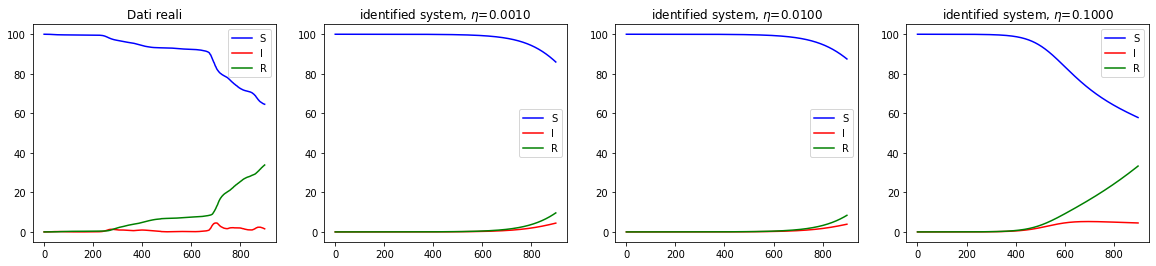

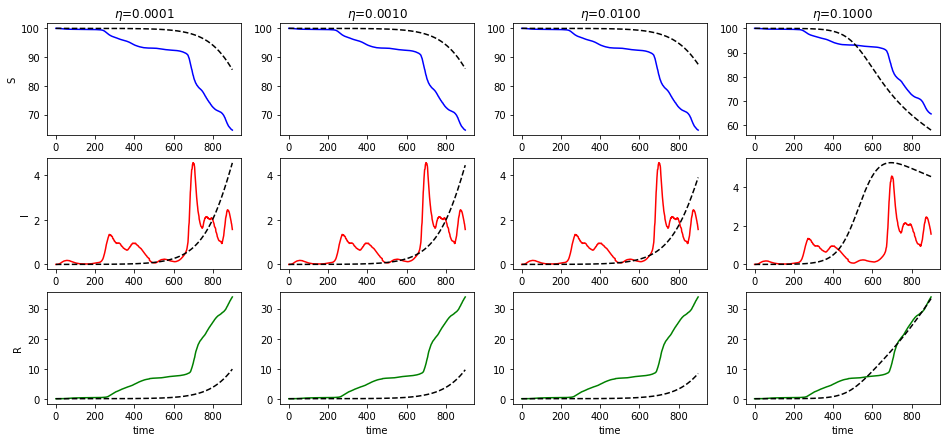

In [35]:
# Plot results

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(141)
ax.plot(t_sim,x_train[: t_sim.size, 0],"b")
ax.plot(t_sim,x_train[: t_sim.size, 1],"r")
ax.plot(t_sim,x_train[: t_sim.size, 2],"g")
plt.title("Dati reali")
plt.legend(['S','I','R'])

model_idx = 1
ax = fig.add_subplot(142)
ax.plot(t_sim,x_sim[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.4f}")
plt.legend(['S','I','R'])

model_idx = 2
ax = fig.add_subplot(143)
ax.plot(t_sim,x_sim[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.4f}")
plt.legend(['S','I','R'])

model_idx = 3
ax = fig.add_subplot(144)
ax.plot(t_sim,x_sim[model_idx][:, 0],"b")
ax.plot(t_sim,x_sim[model_idx][:, 1],"r")
ax.plot(t_sim,x_sim[model_idx][:, 2],"g")
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.4f}")
plt.legend(['S','I','R'])

fig = plt.figure(figsize=(16, 7))
model_idx = 0
ax = fig.add_subplot(341)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.4f}")
plt.ylabel("S")

ax = fig.add_subplot(345)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.ylabel("I")

ax = fig.add_subplot(349)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")
plt.ylabel("R")

model_idx = 1
ax = fig.add_subplot(342)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.4f}")

ax = fig.add_subplot(346)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,10)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")

model_idx = 2
ax = fig.add_subplot(343)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.4f}")

ax = fig.add_subplot(347)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,11)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")

model_idx = 3
ax = fig.add_subplot(344)
ax.plot(t_sim, x_train[: t_sim.size, 0], "b")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.4f}")

ax = fig.add_subplot(348)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")

ax = fig.add_subplot(3,4,12)
ax.plot(t_sim, x_train[: t_sim.size, 2], "g")
ax.plot(t_sim, x_sim[model_idx][:, 2], "k--")
plt.xlabel("time")

fig.show()